In [28]:
import Data.data as d
import Plotting.plotting_functions as pf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

import joblib

# Introdução

**Contexto do Desafio:**

- Uma empresa líder no setor de distribuição gerencia múltiplos centros de distribuição e uma vasta gama de produtos. Com a expansão contínua e o aumento da complexidade das operações, a empresa busca integrar soluções de Machine Learning para melhorar a eficiência logística em várias frentes. 

**Foco**

- Otimizar o armazenamento e a distribuição de produtos.

**Objetivo**

- Criar um sistema que determine os tamanhos ideais de embalagens para diferentes produtos para reduzir o desperdício de material e custos de transporte.

## Dados

In [2]:
df = d.gerar_dados()

In [3]:
df

,ID do Produto,Altura(cm),Largura(cm),Profundidade(cm),Peso do Produto(kg),Material de Embalagem,Custo por Unidade de Material,Volume de Vendas
0,1,23.765990,19.699021,47.757925,20.390538,Papelão,0.984176,567
1,2,37.414602,28.717615,30.049393,21.936560,Papelão,0.339975,395
2,3,5.005147,44.867394,46.202286,17.366125,Plástico,0.580288,966
3,4,18.604966,21.077139,33.870479,14.452613,Isopor,0.383020,227
4,5,11.604015,45.884082,22.550347,4.443800,Papelão,0.919696,371
...,...,...,...,...,...,...,...,...
95,96,15.666214,46.938743,8.069421,21.174091,Plástico,0.567174,314
96,97,45.652078,5.627821,22.006588,9.834895,Papelão,0.828990,357
97,98,30.815577,15.546294,8.583173,18.871529,Plástico,0.111343,172
98,99,5.129165,32.755026,49.226770,13.022966,Isopor,0.705223,407


Verificando valores nulos e duplicados antes de proceder à análise.

In [4]:
df.duplicated().sum()

0

In [5]:
df.isna().sum()

ID do Produto                    0
Altura(cm)                       0
Largura(cm)                      0
Profundidade(cm)                 0
Peso do Produto(kg)              0
Material de Embalagem            0
Custo por Unidade de Material    0
Volume de Vendas                 0
dtype: int64

Diante dessas informações, podemos prosseguir com a análise para entender um pouco mais dos dados fornecidos.

## Análise Exploratória dos Dados

Nessa parte, tentaremos entender um pouco sobre os dados fornecidos.

In [6]:
df.describe()

,ID do Produto,Altura(cm),Largura(cm),Profundidade(cm),Peso do Produto(kg),Custo por Unidade de Material,Volume de Vendas
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,26.864507,26.817757,29.961995,12.997766,0.545918,506.460000
std,29.011492,13.314811,14.302286,12.520033,6.903709,0.262223,262.892513
min,1.000000,5.005147,5.565019,5.018091,1.047095,0.108414,101.000000
25%,25.750000,14.442537,13.771881,20.497507,6.742854,0.335645,263.000000
50%,50.500000,26.183419,29.834829,30.812000,13.544615,0.550796,496.500000
75%,75.250000,37.478429,38.886607,41.155743,18.887526,0.748164,745.250000
max,100.000000,49.498749,49.879528,49.226770,24.850869,0.997078,979.000000


### **Total de Produtos por Material**

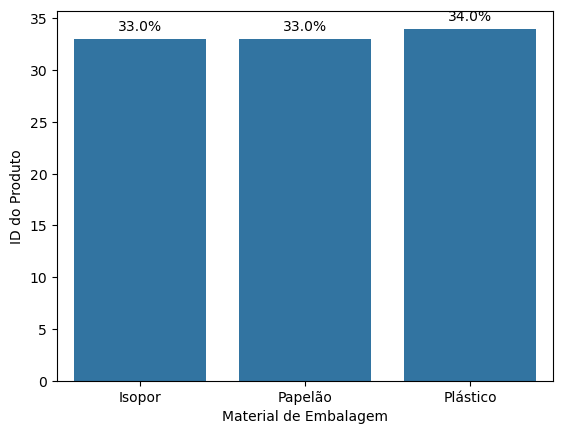

In [7]:
produtor_material = df.groupby('Material de Embalagem').count()['ID do Produto']

ax = sns.barplot(produtor_material)
pf.add_percentage_to_plot(ax)

### **Máximo de Vendas por Material**

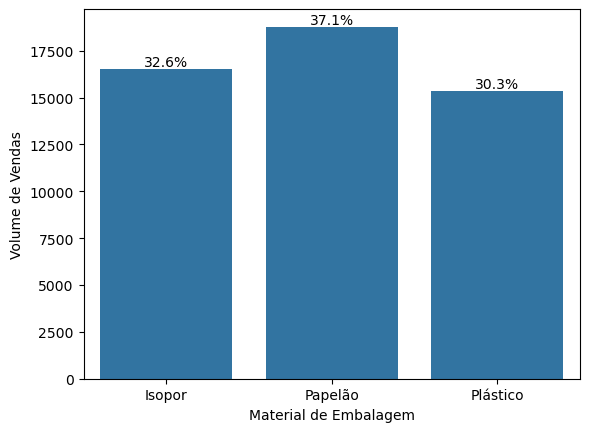

In [8]:
max_vendas = df.groupby('Material de Embalagem').sum()['Volume de Vendas']

ax = sns.barplot(max_vendas)
pf.add_percentage_to_plot(ax)

### **Maior Custo por Unidade por Material**

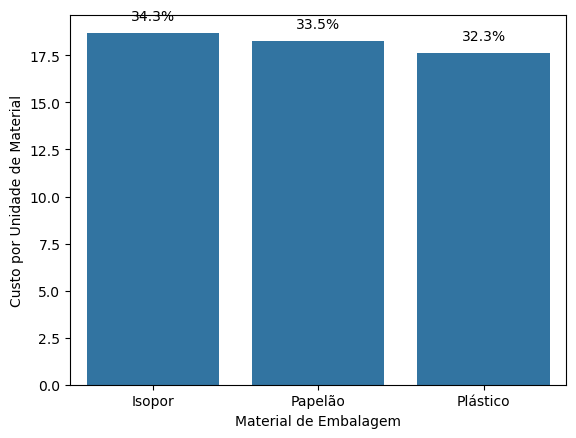

In [9]:
maior_custo = df.groupby('Material de Embalagem').sum()['Custo por Unidade de Material']

ax = sns.barplot(maior_custo)
pf.add_percentage_to_plot(ax)

### **Feature Engineering**

**Calcula o volume ideal da embalagem com margem de proteção**

In [10]:
#Adicionando 10% ao volume relacionado à proteçao;
df = d.calcular_volume_com_protecao(df, 0.1)

**Calcula o peso total (produto + embalagem estimada)**

In [11]:
#Adicionando 1% ao peso relacionado à proteçao;
df = d.calcular_peso_total(df, 0.01)

**Distribuição do Volume Ideal dos Produtos**

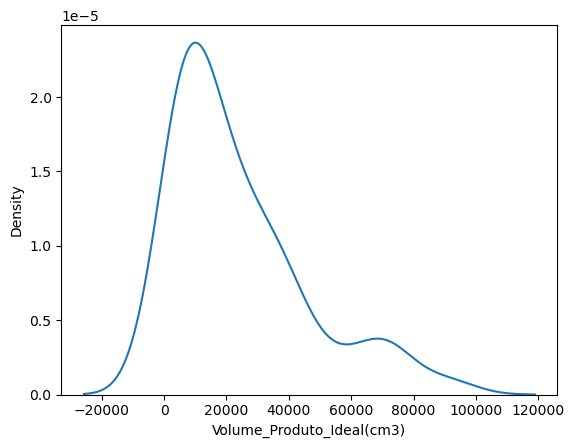

In [13]:
sns.kdeplot(df['Volume_Produto_Ideal(cm3)'])
plt.show()

**Tamanhos De Caixas**

In [14]:
num_bins = 10

# Create bins based on min and max of the feature
bin_labels = [f'Bin_{i}' for i in range(1, num_bins+1)]
df['Caixa_Ideal'] = pd.cut(df['Volume_Produto_Ideal(cm3)'], bins=num_bins, labels=bin_labels)

In [15]:
df.groupby(by='Caixa_Ideal', observed=False)['ID do Produto'].count()

Caixa_Ideal
Bin_1     35
Bin_2     18
Bin_3     15
Bin_4     11
Bin_5      8
Bin_6      2
Bin_7      2
Bin_8      7
Bin_9      0
Bin_10     2
Name: ID do Produto, dtype: int64

In [27]:
df.sample(5)

,ID do Produto,Altura(cm),Largura(cm),Profundidade(cm),Peso do Produto(kg),Material de Embalagem,Custo por Unidade de Material,Volume de Vendas,Volume_Produto_Ideal(cm3),Peso_Total,Caixa_Ideal
70,71,45.653086,19.281308,23.066581,9.214777,Papelão,0.701859,444,22334.825304,9.306924,Bin_3
98,99,5.129165,32.755026,49.226770,13.022966,Isopor,0.705223,407,9097.427898,13.153196,Bin_1
79,80,37.669909,21.653789,40.893746,5.121602,Isopor,0.109800,217,36692.563620,5.172818,Bin_4
43,44,40.517570,10.460456,13.280459,21.425828,Isopor,0.316320,195,6191.555330,21.640087,Bin_1
11,12,35.834878,11.171109,48.346814,22.786070,Isopor,0.901917,869,21289.366890,23.013931,Bin_3


### **Pré-processamento dos Dados**

In [16]:
categorical_columns = ['Material de Embalagem','Caixa_Ideal']

encoder = OneHotEncoder(sparse_output=False)

encoded_values = encoder.fit_transform(df[categorical_columns])
encoded_df = pd.DataFrame(encoded_values, columns=encoder.get_feature_names_out(categorical_columns))

df_encoded = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

df_encoded

,ID do Produto,Altura(cm),Largura(cm),Profundidade(cm),Peso do Produto(kg),Custo por Unidade de Material,Volume de Vendas,Volume_Produto_Ideal(cm3),Peso_Total,Material de Embalagem_Isopor,...,Material de Embalagem_Plástico,Caixa_Ideal_Bin_1,Caixa_Ideal_Bin_10,Caixa_Ideal_Bin_2,Caixa_Ideal_Bin_3,Caixa_Ideal_Bin_4,Caixa_Ideal_Bin_5,Caixa_Ideal_Bin_6,Caixa_Ideal_Bin_7,Caixa_Ideal_Bin_8
0,1,23.765990,19.699021,47.757925,20.390538,0.984176,567,24594.538940,20.594443,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,37.414602,28.717615,30.049393,21.936560,0.339975,395,35515.496513,22.155926,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,5.005147,44.867394,46.202286,17.366125,0.580288,966,11413.105253,17.539786,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,18.604966,21.077139,33.870479,14.452613,0.383020,227,14610.146404,14.597139,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,11.604015,45.884082,22.550347,4.443800,0.919696,371,13207.367028,4.488238,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,15.666214,46.938743,8.069421,21.174091,0.567174,314,6527.254647,21.385831,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,97,45.652078,5.627821,22.006588,9.834895,0.828990,357,6219.367402,9.933244,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,98,30.815577,15.546294,8.583173,18.871529,0.111343,172,4523.116273,19.060244,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,99,5.129165,32.755026,49.226770,13.022966,0.705223,407,9097.427898,13.153196,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train/Test Split

In [17]:
X = df_encoded.drop(columns='Volume_Produto_Ideal(cm3)')
y = df_encoded['Volume_Produto_Ideal(cm3)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modelo

**Linear Regression**

In [23]:
linear = LinearRegression()
linear.fit(X_train, y_train)

y_pred = linear.predict(X_test)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae = mean_absolute_error(y_test, y_pred)
scores = cross_val_score(linear, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

print(f'Mean Absolute Error (Cross-Validation): {-scores.mean()}')
print(f'Mean Absolute Error (Linear Regression): {mae}')

Mean Absolute Error (Cross-Validation): 2265.88995903406
Mean Absolute Error (Linear Regression): 1970.6599804829427


**RandomForest**

In [22]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae = mean_absolute_error(y_test, y_pred)
scores = cross_val_score(rf, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

print(f'Mean Absolute Error (Cross-Validation): {-scores.mean()}')
print(f'Mean Absolute Error: {mae}cm3')

Mean Absolute Error (Cross-Validation): 5415.410106341257
Mean Absolute Error: 2272.8054356228276cm3


**XGB**

In [26]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(xgb, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Absolute Error (Cross-Validation): {-scores.mean()}')
print(f'Mean Absolute Error: {mae}cm3')

Mean Absolute Error (Cross-Validation): 3058.984372607457
Mean Absolute Error: 1751.3212330029394cm3


## Deploy do Melhor Modelo

In [30]:
joblib.dump(xgb, './API/models/xgb_model.pkl')

['./Modelo/xgb_model.pkl']